## Subject based topic analysis

In [1]:
import re
from distfit import distfit
from pyfiles.mod_topic_influence_base import *

In [2]:
%store -r group_publication_titles
# %store -r topic_with_value
# %store -r topic_rank
# %store -r norm_distance_kl
# %store -r norm_distance_tau
%store -r mgp_nodes

In [3]:
%store -r lda_model
%store -r id2word
%store -r prepare_text_for_lda

In [4]:
def subject_wise_approach1(mgp_nodes, group_publication_titles, topic_rank_value): #check the code
    mgp_nodes["MSC"] = mgp_nodes["MSC"].apply(lambda x : str(x).replace("Mathematics Subject Classification@ ",""))
    const_value = 1
    group_head_subject = [mgp_nodes[mgp_nodes["Id"]==k]["MSC"].values[0] 
                          for k,v in group_publication_titles.items() if len(v) > 0]
    top_topic_group_over_interval = [[topics[0] if topics[0] > 0.0 else None 
                                      for topics in intervals] for intervals in topic_rank_value]
    top_topic_over_group = [(subject, Counter(topics).most_common()[0][0]) 
                            for topics, subject in zip(top_topic_group_over_interval,group_head_subject)]
    subject_score = {}
    for subject, topic in top_topic_over_group:
        if subject in subject_score :
            subject_score[subject].append(topic)
        else:
            subject_score[subject] = []
            subject_score[subject].append(topic)
    subject_score = [(subject, Counter(subject_score[subject]).most_common()[0]) 
                     for subject in subject_score]
    subject_freq = Counter(group_head_subject)
    subject_publ_tuple = [(mgp_nodes[mgp_nodes["Id"]==k]["MSC"].values[0], v) 
                          for k,v in group_publication_titles.items() if len(v) > 0]
    subject_publ1 = {}
    for subject, publ in subject_publ_tuple:
        if subject in subject_publ1:
            subject_publ1[subject].extend(publ)
        else:
            subject_publ1[subject] = publ
    subject_year = {subject:[year for publ,year in subject_publ1[subject]] for subject in subject_publ1}
    subject_yl   = {subject: max(subject_year[subject])-min(subject_year[subject]) for subject in subject_year}
    normalize_subject_score =  [(key1, val1[1]/((subject_yl[key1]+const_value)*subject_freq[key1])) 
                                for key1, val1 in subject_score]
    sorted_normalize_subject_score =  sorted(normalize_subject_score, key= lambda x : x[1], reverse=True)
    return sorted_normalize_subject_score

In [5]:
#score = subject_wise_approach1(mgp_nodes, group_publication_titles, topic_rank)

In [6]:
#top_topic_over_group = [(country, Counter(topics).most_common()[0][1]/len(topics)) for topics,country in zip(top_topic_group_over_interval,group_head_country)]

In [7]:
def subject_wise_approach2(mgp_nodes, group_publication_titles):
    mgp_nodes["MSC"] = mgp_nodes["MSC"].fillna("")
    #mgp_nodes["MSC"] = mgp_nodes[~(mgp_nodes["MSC"]=="")].copy()
    mgp_nodes["MSC"] = mgp_nodes["MSC"].apply(lambda x : str(x).replace("Mathematics Subject Classification@ ",""))
    subject_publ_tuple = [(mgp_nodes[mgp_nodes["Id"]==k]["MSC"].values[0], v) 
                          for k,v in group_publication_titles.items() if len(v) > 0] #check for missing subject
    #del subject_publ_tuple[""]
    subject_publ1 = {}
    for subject, publ in subject_publ_tuple:
        if subject in subject_publ1:
            subject_publ1[subject].extend(publ)
        else:
            subject_publ1[subject] = publ
            
    subject_publ = {subject:[publ for publ,year in subject_publ1[subject]] for subject in subject_publ1}
    subject_year = {subject:[year for publ,year in subject_publ1[subject]] for subject in subject_publ1}
    subject_yl   = {subject: max(subject_year[subject])-min(subject_year[subject]) for subject in subject_year}
    subject_topic_dist =  {subject:predict(lda_model, id2word, prepare_text_for_lda, subject_publ[subject]) 
                            for subject in subject_publ}
    subject_top_topic_over_groups = {subject:[get_top_topic(topic) for topic in subject_topic_dist[subject]] 
                                     for subject in subject_topic_dist}
    subject_top_topic = {subject:Counter(subject_top_topic_over_groups[subject]).most_common()[0] 
                         for subject in subject_top_topic_over_groups}
    normalized_score = {subject:subject_top_topic[subject][1]/(subject_yl[subject]+1) 
                        for subject in subject_top_topic}
    sorted_normalized_score =  sorted(normalized_score.items(), key=lambda x:x[1], reverse=True)
    return (sorted_normalized_score, subject_top_topic_over_groups)

In [8]:
def subj_wise_approach3(mgp_nodes, group_publication_titles):
    global lda_model
    global id2word
    global prepare_text_for_lda
    Min_publ=0
#     lda_model, id2word = load_topic_model(topic_model, topic_dict, corpus)
#     lda_model.minimum_probability = 0.0
    num_topics= lda_model.num_topics
    mgp_nodes["MSC"] = mgp_nodes["MSC"].fillna("")
    #mgp_nodes["MSC"] = mgp_nodes[~(mgp_nodes["MSC"]=="")].copy()
    mgp_nodes["MSC"] = mgp_nodes["MSC"].apply(lambda x : str(x).replace("Mathematics Subject Classification@ ",""))
#     subj_publ_tuple = [(mgp_nodes[mgp_nodes["Id"]==k]["University"].values[0].split(" and "), v) for k,v in group_publication_titles.items() if len(v) > Min_publ]
    subj_publ_tuple = [(mgp_nodes[mgp_nodes["Id"]==k]["MSC"].values[0], v) for k,v in group_publication_titles.items() if (len(v) > Min_publ and mgp_nodes[mgp_nodes["Id"]==k]["MSC"].values[0]!="")]
    #del subj_publ_tuple[""]
    #subj_publ_tuple = [(sublist,v) for k,v in subj_publ_tuple for sublist in k]
    subj_publ1 = {}
    for subj, publ in subj_publ_tuple:
        if subj in subj_publ1:
            subj_publ1[subj].extend(publ)
        else:
            subj_publ1[subj] = publ
    #del subj_publ1["Business"]
    subj_year = {subj:[year for publ,year in subj_publ1[subj]] for subj in subj_publ1}
    subject_publ = {country: [(" ".join([publ for publ, year in subj_publ1[country] if yr==year]),yr) for yr in sorted(set(subj_year[country]))] for country in subj_publ1}
    subjects = [k for k,v in subject_publ.items() if len(v) > Min_publ]
    topic_distribution_year = [(topic_distributions_over_interval((k,v), lda_model, id2word,prepare_text_for_lda)) 
                               for k,v in subject_publ.items() if len(v) > Min_publ]
    interval_start_year = [i[0] for i in topic_distribution_year]
    topic_distribution  = [i[1] for i in topic_distribution_year]
    aggregated_distribution_topic_rank = [aggregate_dist_over_interval(dist=dist, i=i, rank=True, no_of_topics= num_topics) for i, dist in enumerate(topic_distribution)]
    aggregated_distribution = [elem[0] for elem in aggregated_distribution_topic_rank]
    topic_with_value        = [elem[1] for elem in aggregated_distribution_topic_rank]
    topic_rank = [[[value[0] for value in interval] for interval in researcher] 
                  for researcher in topic_with_value] #changed
    metric_distance_kl = [get_distance_over_interval(dist, i, kl_divergance) 
                          for i, dist in enumerate(aggregated_distribution)]
    metric_distance_tau = [get_distance_over_interval(rank, i, modified_jaccard_index) 
                           for i, rank in enumerate(topic_rank)]
    norm_distance_kl    = [list(np.array(metrics)/sum(metrics)) if sum(metrics) > 0.0 else metrics 
                           for metrics in metric_distance_kl]
    norm_distance_tau   = [list(np.array(metrics)/sum(metrics)) if sum(metrics) > 0.0 else metrics 
                           for metrics in metric_distance_tau]
    assert len(interval_start_year) == len(aggregated_distribution) == len(metric_distance_kl) == len(metric_distance_tau) == len(subjects) == len(norm_distance_kl)==len(norm_distance_tau)
    return (subjects, interval_start_year, norm_distance_kl, norm_distance_tau)

In [9]:
# def get_top_topic(topic):
#     top_topic = None
#     sorted_topic = sorted(topic, key=lambda x:x[1], reverse=True)
#     if sorted_topic[0][1] > 0.0:
#         top_topic = sorted_topic[0][0]
#     return top_topic

In [10]:
did1 = lambda x: abs(np.diff(x, len(x)-1)[0])/len(x) #difference in difference

In [11]:
wrap = lambda x : " ".join(x.split()[0:3]+["\n"]+x.split()[3:]) if len(x.split(" ")) > 3 else x

In [12]:
#country_top_topic_over_groups["UnitedStates"]

In [13]:
#score2, subject_top_topic_over_groups = subject_wise_approach2(mgp_nodes, group_publication_titles)

In [15]:
#score2[1:11]

In [ ]:
score2[-10:][::-1]

In [ ]:
fontsize=18

In [ ]:
mgp_nodes.columns

In [ ]:
top_subjects = {wrap(re.split(r"[^a-zA-Z0-9\s]",k)[1]):v for k, v in score2[1:11]}

In [ ]:
top_population = [mgp_nodes[mgp_nodes["MSC"]==k].shape[0] for k, v in score2[1:11]]

In [ ]:
top_subjects

In [ ]:
#list(top_subjects.keys())[0].split("\b")

In [ ]:
fig, ax1 = plt.subplots()
#fig = plt.figure(figsize = (10, 8))
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.40, 0.6, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.bar(top_subjects.keys(), top_subjects.values(), color ='maroon', width = 0.4)
#ax1.set_xticks(rotation=30, fontsize=fontsize-2)
ax1.set_xticklabels(top_subjects.keys(), rotation=55, ha='right',weight="bold")
ax2.bar(range(len(top_population)),top_population)
ax2.set_xticks(range(len(top_population)))
ax2.set_xlabel("Top 10 Subject (in same order)",fontsize=fontsize-8)
ax2.set_ylabel("Frequency", fontsize=fontsize-8)

ax1.set_xlabel("Subject Name",fontsize=fontsize)
ax1.set_ylabel("Consistency Score", fontsize=fontsize)
plt.savefig(f"{fig_folder}/top_10_subject.pdf",bbox_inches="tight")
#plt.title("Students enrolled in different courses")
plt.show()

In [ ]:
# fig = plt.figure(figsize = (10, 8))
# plt.bar(top_subjects.keys(), top_subjects.values(), color ='orange', width = 0.4)

# plt.xticks(rotation=90, fontsize=fontsize-2, wrap=True)

# plt.xlabel("Subject Name",fontsize=fontsize)
# plt.ylabel("Consistency Score", fontsize=fontsize)
# plt.savefig(f"{fig_folder}/top_10_subject.pdf",bbox_inches="tight")
# #plt.title("Students enrolled in different courses")
# plt.show()

In [ ]:
last_subjects   = {wrap(re.split(r"[^a-zA-Z0-9\s]",k)[1]):v for k, v in score2[-10:][::-1]}

In [ ]:
last_population = [mgp_nodes[mgp_nodes["MSC"]==k].shape[0] for k, v in score2[-10:][::-1]]

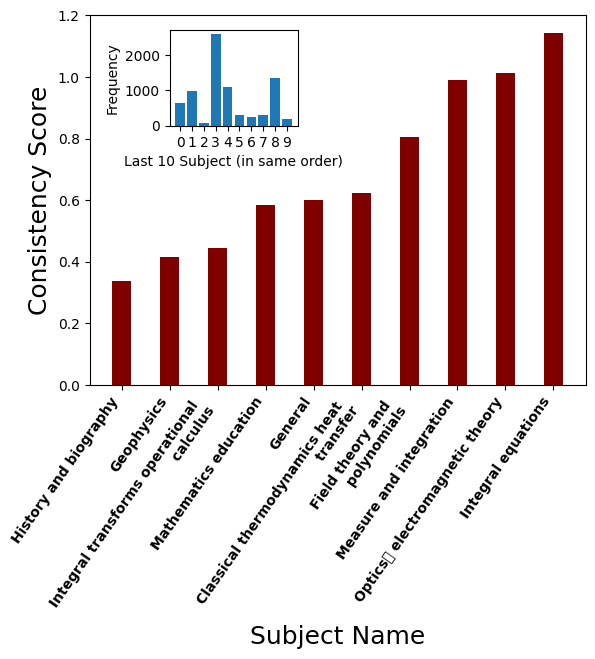

In [33]:
fig, ax1 = plt.subplots()
#fig = plt.figure(figsize = (10, 8))
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.25, 0.65, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.bar(last_subjects.keys(), last_subjects.values(), color ='maroon', width = 0.4)
#ax1.set_xticks(rotation=30, fontsize=fontsize-2)
ax1.set_xticklabels(last_subjects.keys(), rotation=55, ha='right',weight="bold")
ax1.set_xlabel("Subject Name",fontsize=fontsize)
ax1.set_ylabel("Consistency Score", fontsize=fontsize)

ax2.bar(range(len(last_population)),last_population)
ax2.set_xticks(range(len(last_population)))
ax2.set_xlabel("Last 10 Subject (in same order)",fontsize=fontsize-8)
ax2.set_ylabel("Frequency", fontsize=fontsize-8)


plt.savefig(f"{fig_folder}/last_10_subject.pdf",bbox_inches="tight")
#plt.title("Students enrolled in different courses")
plt.show()

In [28]:
# fig = plt.figure(figsize = (10, 8))
# plt.bar(last_subjects.keys(), last_subjects.values(), color ='orange', width = 0.4)

# plt.xticks(rotation=90,fontsize=fontsize-2,wrap=True)

# plt.xlabel("Subject Name", fontsize=fontsize)
# plt.ylabel("Consistency Score", fontsize=fontsize)
# plt.savefig(f"{fig_folder}/last_10_subject.pdf",bbox_inches="tight")
# #plt.title("Students enrolled in different courses")
# plt.show()

### Third Approach

In [12]:
# def group_plot_metric(mgp_ids, year, metric_dist, researcher_id, name="", flag="", ylim=None):
#     if flag=="researcher":
#         txt= "MGP ID: "
#     else:
#         txt = ""
#     indexs =  [i for i, idd in enumerate(researcher_id) if idd in mgp_ids]
#     if len(indexs) > 0:
#         metric_dist = [[np.round(float(i), 2) for i in nested] for nested in metric_dist]
#         plt.figure(figsize=(8, 6), dpi=80)
#         for index in indexs:
            
#             if len(year[index][1:]) > 0:
#                 print(year[index])
#                 plt.plot(year[index][1:], metric_dist[index], label=f"{txt}{researcher_id[index]}",                             marker='o', markersize=5)
#             else:
#                 plt.plot(year[index], metric_dist[index], label=f"{txt}{researcher_id[index]}", marker='o',                     markersize=5)
#         plt.ylabel("Topic Distance Over Interval")#
#         plt.xlabel("Publication Year")
#         plt.ylim(ylim)
#         plt.legend()
#         plt.savefig(f"{fig_folder}/{name}.pdf")
#         plt.show()
#     else:
#         print(f"Advisor (Group leader : {mgp_id}) not present in the filtered dataset")
#     return

In [16]:
subjects, interval_start_year, norm_distance_kl, norm_distance_tau= subj_wise_approach3(mgp_nodes, group_publication_titles)

In [17]:
did3 = lambda x:(np.std(np.diff(x,1))*np.std(x))

In [18]:
did  = lambda x: (np.std([abs(d) for d in np.diff(x,1)])*np.std(x))

In [19]:
# With modified jaccard co-efficient MJC
metric_std_tau   = [did(interval) for interval in norm_distance_tau]

# with Kullback–Leibler divergence (KL-Divergance)
metric_std_kl   = [did(interval) for interval in norm_distance_kl]

#Peaks calculation for MJC And KLD
metric_peaks_tau = [len(find_peaks(interval)[0]) for interval in norm_distance_tau]
metric_peaks_kl = [len(find_peaks(interval)[0]) for interval in norm_distance_kl]

#set(sorted(univ_year["The subjects of Chicago"]))

persistent_res_kl, anti_persistent_res_kl,res_kl = find_from_filtered_top_lowest(metric_std_kl, subjects, zero_include=False, top=10, index_between=(0,len(subjects)))

persistent_res_tau, anti_persistent_res_tau, res_tau = find_from_filtered_top_lowest(metric_std_tau, subjects, zero_include=False, top=10, index_between=(0,len(subjects)))

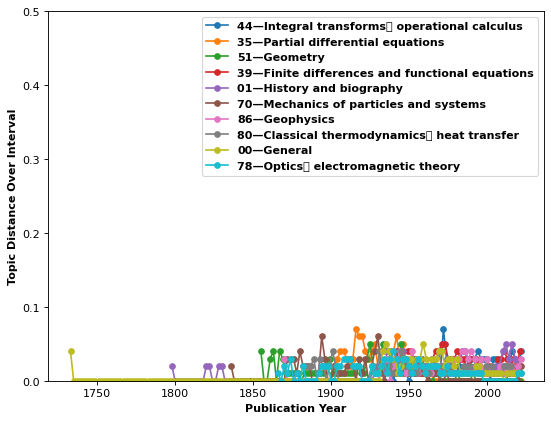

In [20]:
group_plot_metric(persistent_res_kl[:10], interval_start_year, norm_distance_kl, subjects, name="persistent_kl_subject",ylim=(0, 0.5))

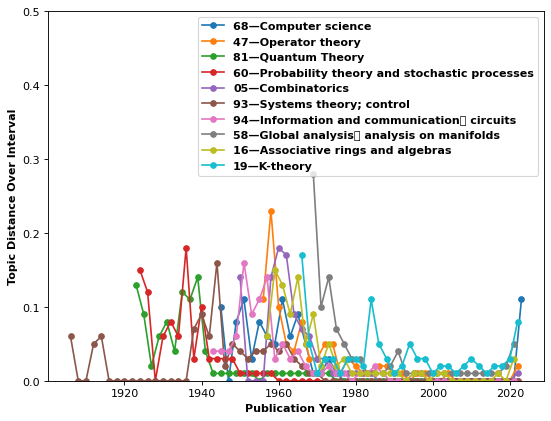

In [21]:
group_plot_metric(anti_persistent_res_kl[:10], interval_start_year, norm_distance_kl, subjects, name="anti_persistent_kl_subject", ylim=(0,0.5))

In [22]:
persistent_res_kl

['78—Optics\t electromagnetic theory',
 '39—Finite differences and functional equations',
 '01—History and biography',
 '00—General',
 '80—Classical thermodynamics\t heat transfer',
 '86—Geophysics',
 '51—Geometry',
 '44—Integral transforms\t operational calculus',
 '70—Mechanics of particles and systems',
 '35—Partial differential equations']

In [23]:
anti_persistent_res_kl

['58—Global analysis\t analysis on manifolds',
 '05—Combinatorics',
 '47—Operator theory',
 '60—Probability theory and stochastic processes',
 '68—Computer science',
 '16—Associative rings and algebras',
 '94—Information and communication\t circuits',
 '19—K-theory',
 '81—Quantum Theory',
 '93—Systems theory; control']